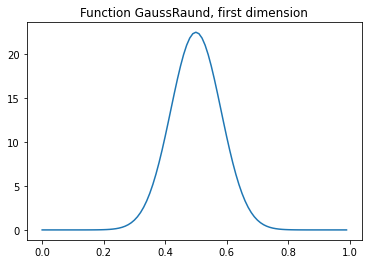

In [2]:
NDIM = 3
NEVENTS = 1000
NITER = 5

class ExampleFun(abc.ABC):
    
    _ndim = NDIM
    
    def __init__(self, rtbm=False):
        self.rtbm = rtbm
    
    @abc.abstractmethod
    def _functional_form(self, x):
        # The input to this function will always be in the form
        # (nevents, ndim)
        pass
    
    def __call__(self, x, n_dim=None, **kwargs):
        # Ensure the input is (nevents, ndim)
        if len(x.shape) == 1:
            x = x.reshape(-1,1)
        if x.shape[-1] != self._ndim:
            if x.shape[0] == self._ndim:
                x = x.T
            else:
                raise ValueError(f"Wrong input shape: {x.shape}")
        # and the output (nevents,)
        if self.rtbm:
            return self._functional_form(x).reshape(1, -1)
        else:
            return self._functional_form(x)
    
class f1d(ExampleFun):
    def _functional_form(self, x):
        return x[:, 0]
    
class GaussRaund(ExampleFun):
    
    _a = 0.2
    
    def __init__(self, ndim=1, **kwargs):
        self.ndim = ndim
        super().__init__(**kwargs)
         
    def _functional_form(self, x):
        n100 = 100*self.ndim
        pref = pow(1.0 / self._a / np.sqrt(np.pi), self.ndim)
        coef = np.sum(np.arange(n100 + 1))
        coef += np.sum(np.square((x - 1.0 / 2.0) / self._a), axis=1)
        coef -= (n100 + 1) * n100 / 2.0
        return pref * np.exp(-coef)
    
def get_n_points(n, ndim=NDIM):
    x1d = np.arange(n)/n
    x = np.repeat(x1d[:, None], ndim, axis=1)
    return x
x = get_n_points(100)
plt.plot(x[:,0], GaussRaund(ndim=NDIM)(x))
plt.title("Function GaussRaund, first dimension");

In [3]:
# Testing the Vegasflow training
vflow = VegasFlow(NDIM, NEVENTS, verbose=False)
vegas_fun = GaussRaund(NDIM)
vflow.compile(vegas_fun, compilable=False)
vflow.set_seed(1)
all_divs = [vflow.divisions.numpy()]
for _ in range(NITER):
    solv = vflow.run_integration(1, log_time=False)
    # Save the grid at every dimension to get an idea on how much it actually changes
    all_divs.append(vflow.divisions.numpy())
print(f"Importance Sampling result {solv[0]:.4} +- {solv[1]:.4}")
all_divs = np.stack(all_divs, axis=0)
    
rnumbers, ind, w = vflow.generate_random_array(NEVENTS)
rnumbers = rnumbers.numpy()

Importance Sampling result 0.9937 +- 0.007394


Dimension: 1


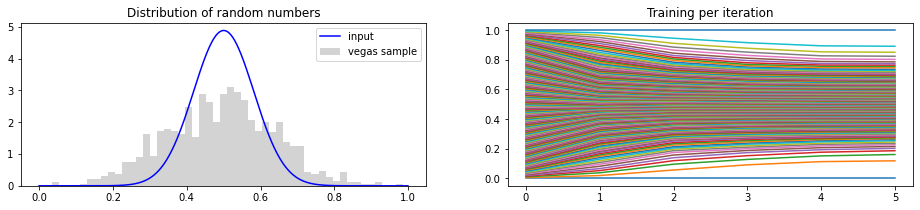

Dimension: 2


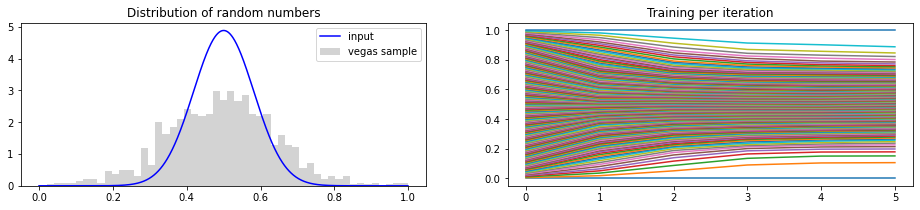

Dimension: 3


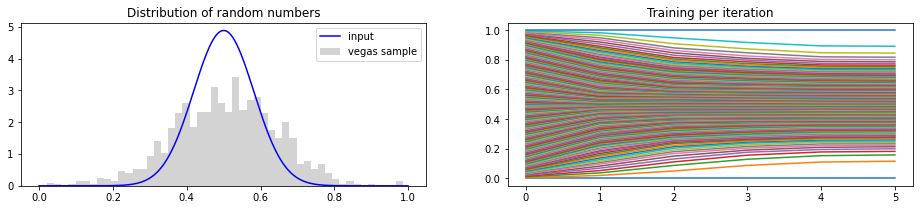

In [4]:
x = get_n_points(NEVENTS)
y = vegas_fun(x)
y = y/np.sum(y)*NEVENTS
iters = np.arange(NITER+1)
plt.rcParams['figure.figsize'] = [16, 3]

for d in range(NDIM):
    print(f"Dimension: {d+1}")
    plt.subplot(1,2,1)
    plt.plot(x[:,d], y/sum(y)*NEVENTS, color="blue", label='input')
    plt.hist(rnumbers[:,d], bins=50, density=True, color="lightgray", label='vegas sample')
    plt.legend()
    plt.title(f"Distribution of random numbers")
    plt.subplot(1,2,2)
    for div in all_divs.T:
        plt.plot(iters, div[d])
    plt.title(f"Training per iteration")
    plt.show()

In [5]:
from theta.rtbm import RTBM
from theta.minimizer import CMA
from theta import costfunctions as losses
# Testing the RTBM
NV = 2
REVENTS=500
model = RTBM(NDIM, NV, init_max_param_bound=50, random_bound=1, diagonal_T=True)
try:
    optimizer = CMA(parallel=True, ncores=1, verbose=True)
except TypeError:
    optimizer = CMA(parallel=True, ncores=1)
fun = GaussRaund(ndim=NDIM, rtbm=True)

xx = np.random.rand(NDIM, REVENTS)
yy = fun(xx)
yy = yy/np.sum(yy)

solution = optimizer.train(losses.kullbackLeibler, model, xx, yy, popsize=50, tolfun=1e-1, maxiter=2)

CMA on 1 cpu(s) enabled
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 17 (seed=468434, Tue Feb  2 20:23:57 2021)


/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning:   999 solutions rejected (f-value NaN or None) at iteration 0 ()
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning:   1999 solutions rejected (f-value NaN or None) at iteration 0 ()
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning:   2999 solutions rejected (f-value NaN or None) at iteration 0 ()
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning:   3999 solutions rejected (f-value NaN or None) at iteration 0 ()
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma/utilities/utils.py:343: UserWarning:   4999 solutions rejected (f-value NaN or None) at iteration 0 ()
  warnings.warn(msg + ' (' +
/media/storageSSD/Academic_Workspace/N3PDF/src/pycma/cma

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 1.431610760883347e+00 1.0e+00 7.58e+00  7e+00  8e+00 0:00.0
    2    100 1.145667360092903e+00 1.3e+00 1.32e+01  1e+01  1e+01 0:00.7
CMAEvolutionStrategyResult(xbest=array([ -1.30984466, -21.24924077,  -5.46977311,   5.91956824,
        12.36513378,   3.18665803,   0.23403294,  -6.56468421,
        -3.97898161,   7.02723266,   0.78967343,   9.50721159,
        24.97230833,   8.29955603,  18.68254019,   2.30138078,
        13.84323334]), fbest=1.145667360092903, evals_best=95, evaluations=100, iterations=2, xfavorite=array([-3.82362925, -4.82124262, -2.14056876,  1.61168949,  3.10616794,
       -0.98123701,  1.61904872,  0.98100292,  0.81722016,  0.33160299,
       -0.65396934, 10.90480588, 15.44336589, 10.94396284, 17.04711671,
        0.63468952, 12.03762078]), stds=array([12.79038162, 13.01186856, 12.36056089, 12.38407314, 12.36994573,
       13.07813967, 12.95447601, 13.13572151, 13.04675145, 13.101

Dimension: 1


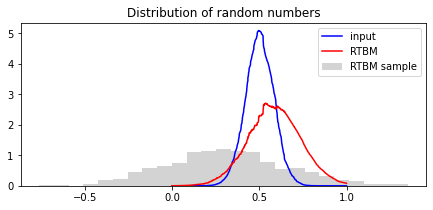

Dimension: 2


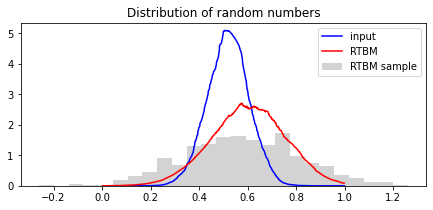

Dimension: 3


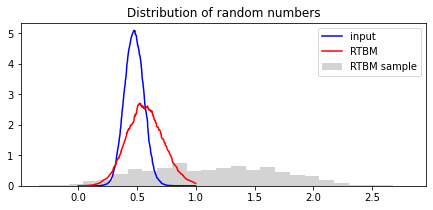

In [6]:
x = np.random.rand(NDIM, NEVENTS)
x.sort()
y = fun(x)[0]
y = y/np.sum(y)*NEVENTS
iters = np.arange(NITER+1)
plt.rcParams['figure.figsize'] = [16, 3]

result_rtbm = model(x)[0]
result_rtbm = result_rtbm/np.sum(result_rtbm)*NEVENTS
rnumbers_rtbm, _ = model.make_sample(NEVENTS)

for d in range(NDIM):
    print(f"Dimension: {d+1}")
    plt.subplot(1,2,1)
    plt.plot(x[d,:], y, color="blue", label='input')
    plt.plot(x[d,:], result_rtbm, color="red", label="RTBM")
    plt.hist(rnumbers_rtbm[:,d], bins=25, density=True, color="lightgray", label='RTBM sample')
    plt.legend()
    plt.title(f"Distribution of random numbers")
    plt.show()